<a href="https://colab.research.google.com/github/Yeechin-is-here/ds301-final-project/blob/main/%E3%80%8CWGAN_dataset1_ipynb%E3%80%8D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Changes camparing to DCGAN:
1. Cancel sigmoid function in discriminator
2. WGAN weight clipping-- clip discriminator weights between -0.01, 0.01
3. G_loss, D_loss change according to WGAN criteria
4. Change optimizer from Adam to RMSProp


paper: [Wasserstein GAN](https://arxiv.org/abs/1701.07875)

## 1. Import dataset & data preprocess

See details in utils/data_preprocess.ipynb

In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
!unzip /content/drive/MyDrive/301_Final_proj/images.zip -d /content/images


串流輸出內容已截斷至最後 5000 行。
  inflating: /content/images/images/62764_2019.jpg  
  inflating: /content/images/images/62765_2019.jpg  
  inflating: /content/images/images/62766_2019.jpg  
  inflating: /content/images/images/62767_2019.jpg  
  inflating: /content/images/images/62768_2019.jpg  
  inflating: /content/images/images/62769_2019.jpg  
  inflating: /content/images/images/6276_2003.jpg  
  inflating: /content/images/images/62770_2019.jpg  
  inflating: /content/images/images/62771_2019.jpg  
  inflating: /content/images/images/62772_2019.jpg  
  inflating: /content/images/images/62773_2019.jpg  
  inflating: /content/images/images/62774_2019.jpg  
  inflating: /content/images/images/62775_2019.jpg  
  inflating: /content/images/images/62776_2019.jpg  
  inflating: /content/images/images/62777_2019.jpg  
  inflating: /content/images/images/62778_2019.jpg  
  inflating: /content/images/images/62779_2019.jpg  
  inflating: /content/images/images/6277_2003.jpg  
  inflating: /content/image

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import numpy as np

import os

In [ ]:
anime_data_dir = "/content/images"


In [ ]:
train_images = tf.keras.utils.image_dataset_from_directory(
    anime_data_dir, label_mode=None, image_size=(64, 64), batch_size=256 # update from 32
)

Found 63565 files belonging to 1 classes.


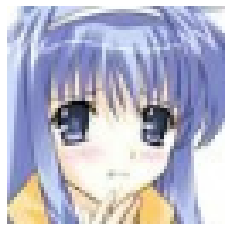

In [ ]:
image_batch = next(iter(train_images))
random_index = np.random.choice(image_batch.shape[0])
random_image = image_batch[random_index].numpy().astype("int32")

# Visualize 1 random image from the training dataset
plt.axis("off")
plt.imshow(random_image)
plt.show()

In [ ]:
def show(images):
    plt.figure(figsize=(4, 4))

    for i in range(16):
        plt.subplot(4, 4, i+1)
        img = keras.utils.array_to_img(images[i]) 
        plt.imshow(img)
        plt.axis('off') 
    plt.show()

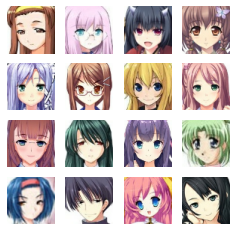

In [ ]:
show(image_batch[:16])

In [ ]:
# Normalize the images to [-1, 1] which is the range of the tanh activation
train_images = train_images.map(lambda x: (x - 127.5) / 127.5)

In [ ]:
# latent dimension of the random noise
LATENT_DIM = 128 
# weight initializer for G per DCGAN paper 
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 3  

In [ ]:
def build_generator():
    # create a Keras Sequential model 
    model = Sequential(name="generator")

    # prepare for reshape: FC => BN => RN layers, note: input shape defined in the 1st Dense layer  
    model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
    # model.add(layers.BatchNormalization()) 
    model.add(layers.ReLU())
    # layers.LeakyReLU(alpha=0.2),

    # 1D => 3D: reshape the output of the previous layer 
    model.add(layers.Reshape((8, 8, 512)))

    # upsample to 16x16: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(256, (4, 4), 
                                     strides=(2, 2), 
                                     padding="same", 
                                     use_bias=False, 
                                     kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization()) # Margaret exp: add back bach norm
    model.add((layers.ReLU()))

    # upsample to 32x32: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(128, (4, 4), 
                                     strides=(2, 2), 
                                     padding="same", 
                                     use_bias=False, 
                                     kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization()) # Margaret exp: add back bach norm
    model.add((layers.ReLU()))

    # upsample to 64x64: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(64, (4, 4), 
                                     strides=(2, 2), 
                                     padding="same", 
                                     use_bias=False, 
                                     kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization()) # Margaret exp: add back bach norm
    model.add((layers.ReLU()))

    # final layer: Conv2D with tanh activation
    model.add(layers.Conv2D(CHANNELS, (4, 4), padding="same", activation="tanh"))

    # return the generator model
    return model

In [ ]:
# build the generator model
generator = build_generator()

In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             4227072   
                                                                 
 re_lu (ReLU)                (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      2097152   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 256)      1024      
 ormalization)                                                   
                                                                 
 re_lu_1 (ReLU)              (None, 16, 16, 256)       0 

In [ ]:
# UPDATE for WGAN: a new class implementing weight clipping constraint
class WeightClipping(tf.keras.constraints.Constraint):
    def __init__(self, clip_value):
        self.clip_value = clip_value
    
    def __call__(self, weights):
        return tf.clip_by_value(weights, -self.clip_value, self.clip_value)
    
    def get_config(self):
        return {'clip_value': self.clip_value}

In [ ]:
def build_critic(height, width, depth, alpha=0.2):
    #UPDATE for WGAN: enfoce 1-Lipschitz constraint with weight clippping to [-1, 1] 
    constraint = WeightClipping(0.01)

    # create a Keras Sequential model
    model = Sequential(name="critic")
    input_shape = (height, width, depth)

    # 1. first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(64, (4, 4), padding="same", 
                            strides=(2, 2),
                            kernel_constraint = constraint, # UPDATE for WGAN
                            input_shape=input_shape))
    # model.add(layers.BatchNormalization()) 
    model.add(layers.LeakyReLU(alpha=alpha))

    # 2. second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), padding="same", 
                            strides=(2, 2), 
                            kernel_constraint = constraint,)) # UPDATE for WGAN
    # model.add(layers.BatchNormalization()) 
    model.add(layers.LeakyReLU(alpha=alpha))

    # 3. third set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), padding="same", 
                            strides=(2, 2),
                            kernel_constraint = constraint,)) # UPDATE for WGAN
    # model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # flatten and apply dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3)) 

    # UPDATE for WGAN: linear activation in the last layer. 
    # Note: Keras `Dense` layer by default is already a `linear` activation
    model.add(layers.Dense(1, activation="linear"))

    # return the critic model
    return model

In [ ]:
# build the critic model
critic = build_critic(64, 64, 3) 

In [ ]:
class WGAN(keras.Model):
    def __init__(self, 
                 critic, 
                 generator, 
                 latent_dim, 
                 critic_extra_steps): # UPDATE
        super().__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.c_extra_steps = critic_extra_steps
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    # UPDATE for WGAN: remove the code of real / fake labels
    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # UPDATE for WGAN: we train the critic more often than the generator by 5 times (self.c_extra_steps) 
        for i in range(self.c_extra_steps):
            # Step 1. Train the critic with both real images and fake images 
            with tf.GradientTape() as tape:
                # Get the critic' predictions on the real images
                pred_real = self.critic(real_images, training=True)
                # Generate fake images from the latent noise
                fake_images = self.generator(noise, training=True) 
                # Get the critic' predictions on the fake images
                pred_fake = self.critic(fake_images, training=True)
                # Calculate the critic loss with wassertein loss function
                d_loss = self.d_loss_fn(pred_real, pred_fake)
            # Compute critic gradients
            grads = tape.gradient(d_loss, self.critic.trainable_variables)
            # Update critic weights
            self.d_optimizer.apply_gradients(zip(grads, self.critic.trainable_variables))

        # Step 2. Train the generator (do not update weights of the critic)
        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.critic(fake_images, training=True)
            g_loss = self.g_loss_fn(pred_fake) 
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator weights
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during traing
        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img)
            plt.axis('off')
        plt.savefig('epoch_{:03d}.png'.format(epoch)) 
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

In [ ]:
wgan = WGAN(critic=critic, 
              generator=generator, 
              latent_dim=LATENT_DIM,
              critic_extra_steps=5) # UPDATE for WGAN

In [ ]:
# Wasserstein loss for the critic
def d_wasserstein_loss(pred_real, pred_fake):
    real_loss = tf.reduce_mean(pred_real)
    fake_loss = tf.reduce_mean(pred_fake)
    return fake_loss - real_loss

# Wasserstein loss for the generator
def g_wasserstein_loss(pred_fake):
    return -tf.reduce_mean(pred_fake)

In [ ]:
LR = 0.00005 # UPDATE for WGAN: learning rate per WGAN paper

In [ ]:
wgan.compile(
    d_optimizer = keras.optimizers.RMSprop(learning_rate=LR, clipvalue=1.0, decay=1e-8), # UPDATE for WGAN: use RMSProp instead of Adam
    g_optimizer = keras.optimizers.RMSprop(learning_rate=LR, clipvalue=1.0, decay=1e-8), # UPDATE for WGAN: use RMSProp instead of Adam
    d_loss_fn = d_wasserstein_loss,
    g_loss_fn = g_wasserstein_loss
)

Epoch 1/50
249/249 [==============================] - ETA: 0s - d_loss: -52.5208 - g_loss: -15.2228

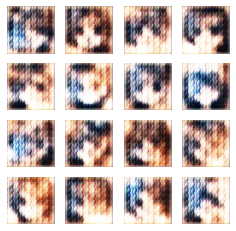

249/249 [==============================] - 306s 1s/step - d_loss: -52.5208 - g_loss: -15.2228
Epoch 2/50
249/249 [==============================] - ETA: 0s - d_loss: -96.8045 - g_loss: 7.5997

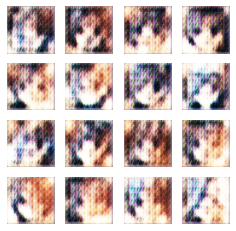

249/249 [==============================] - 305s 1s/step - d_loss: -96.8045 - g_loss: 7.5997
Epoch 3/50
249/249 [==============================] - ETA: 0s - d_loss: -151.2276 - g_loss: 47.3527

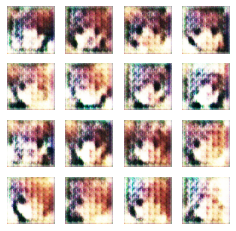

249/249 [==============================] - 305s 1s/step - d_loss: -151.2276 - g_loss: 47.3527
Epoch 4/50
249/249 [==============================] - ETA: 0s - d_loss: -182.2211 - g_loss: 40.8472

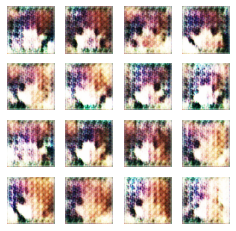

249/249 [==============================] - 305s 1s/step - d_loss: -182.2211 - g_loss: 40.8472
Epoch 5/50
118/249 [=============>................] - ETA: 2:39 - d_loss: -210.3831 - g_loss: 24.0196

In [ ]:
NUM_EPOCHS = 50 # number of epochs
wgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])

Example input images:


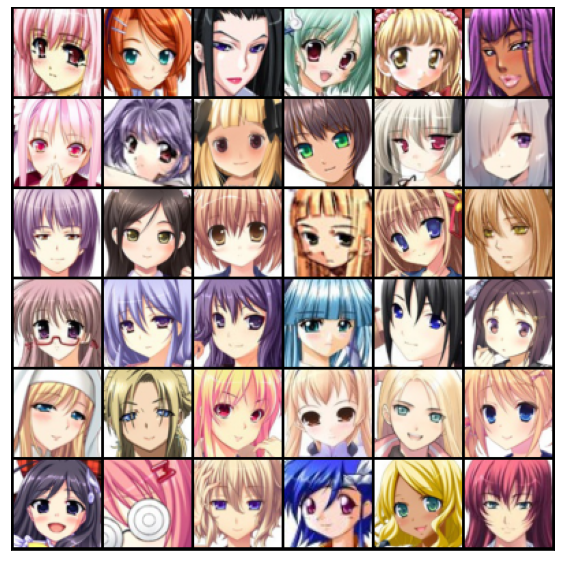

In [ ]:
%run /content/drive/MyDrive/301_Final_proj/codes/utils/data_preprocess.ipynb

## 2. Load DCGAN base architecture


In [ ]:
!pip install torchsummary
import torch.nn as nn
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Inputs for the run:
# Number of workers for dataloader
workers = 2
batch_size = 128
image_size = 64
nc = 3    # Number of channels in the training images. For color images this is 3
latent_size = 128  # Size of z latent vector (i.e. size of generator input)
ngf = 64  # Size of feature maps in generator
ndf = 64  # Size of feature maps in discriminator
epochs = 20
lr = 0.0002
betas = (0.5, 0.999)
ngpu = 1  # Number of GPUs available. Use 0 for CPU mode.
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # in: latent_size x 1 x 1
            #512 = ngf * 8
            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # out: 512 x 4 x 4

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # out: 256 x 8 x 8

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # out: 128 x 16 x 16

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # out: 64 x 32 x 32

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # out: 3 x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 64 x 32 x 32

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 x 8 x 8

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 512 x 4 x 4

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # out: 1 x 1 x 1

            nn.Flatten(),
            #nn.Sigmoid()-- No sigmoid in WGAN network
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

torch.Size([128, 3, 64, 64])


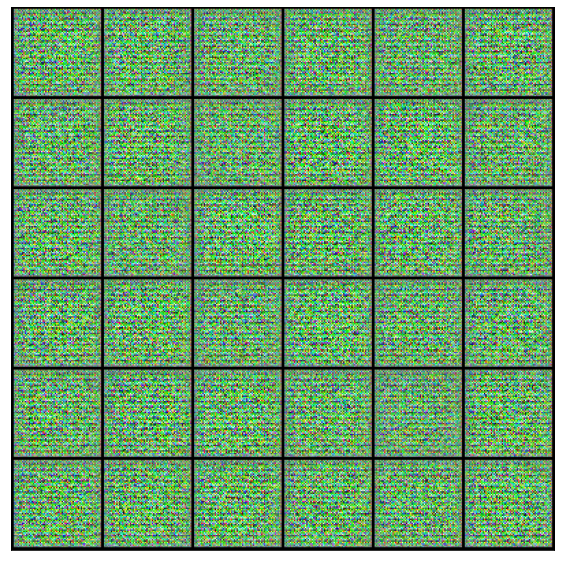

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)
discriminator = to_device(discriminator, device)

In [ ]:
print(color.BOLD + color.UNDERLINE + color.DARKCYAN + 'Architecture of generator:' + color.END)

print(summary(generator,(latent_size,1,1)))

Architecture of generator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,048,576
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
            

In [ ]:
print(color.BOLD + color.UNDERLINE + color.DARKCYAN + 'Architecture of discriminator:' + color.END)
print(summary(discriminator,(3,64,64)))

Architecture of discriminator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Conv2d-13              [-1, 1, 1, 1]           8,192
        

## Train WGAN


In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torch.autograd import Variable

In [ ]:
sample_dir = 'generated_wgan/images'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = '{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving 0000.png


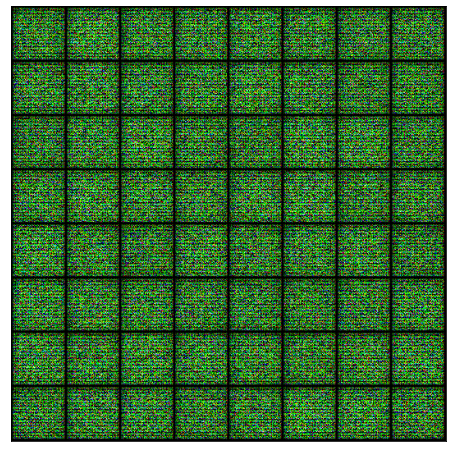

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

initialize_weights(discriminator)
initialize_weights(generator)


In [ ]:
generator = Generator()
discriminator = Discriminator()
generator = to_device(generator, device)
discriminator = to_device(discriminator, device)

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    
    # Create optimizers
    optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=lr)
    optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=lr)
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):

            # Train discriminator
            # Clear discriminator gradients
            optimizer_D.zero_grad()

            # Pass real images through discriminator
            real_preds = discriminator(real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = generator(latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = discriminator(fake_images)

            # Update discriminator weights
            loss_d = -torch.mean(real_preds) + torch.mean(fake_preds)
            loss_d.backward()
            optimizer_D.step()
            loss_d = loss_d.item()

            #WGAN weight clipping-- clip weights between -0.01, 0.01
            for p in discriminator.parameters():
              p.data.clamp_(-0.01, 0.01)


            # Clear generator gradients
            optimizer_G.zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = generator(latent)
            
            # Try to fool the discriminator
            preds = discriminator(fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = -torch.mean(fake_images)
            
            # Update generator weights
            loss_g.backward()
            optimizer_G.step()

            loss_g = loss_g.item()
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
import torch

In [ ]:
epochs=1

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/1], loss_g: -1.0000, loss_d: -1.5117
Saving 0001.png


NameError: ignored

In [ ]:
losses_g_dcgan, losses_d_dcgan, real_scores_dcgan, fake_scores_dcgan = history

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')